In [123]:
#import all required packages
import os
import numpy as np
import matplotlib.pyplot as plt

from astropy.convolution import Gaussian2DKernel
from astropy.stats import gaussian_fwhm_to_sigma
from astropy.visualization import SqrtStretch, simple_norm
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.io import fits,ascii
from astropy.wcs import WCS
from astropy import units as u
from astropy.stats import sigma_clipped_stats
from astropy.table import join

from photutils.aperture import SkyCircularAperture,SkyCircularAnnulus,aperture_photometry 
from photutils.segmentation import detect_threshold, detect_sources, deblend_sources, SourceCatalog
from photutils.background import Background2D, MedianBackground, SExtractorBackground, MMMBackground
from photutils.utils import calc_total_error

In [124]:
#data path
dpath='C:/Users/mhankins1/Documents/SofiaLegacyProgram/SOFIA_Cycle7_Data/SgrBandNearby'
dpathalt='E:\Documents\SofiaLegacyProgram\CAL_files\CAL_R'

#file name
fname='F0588_FO_IMA_0701899_FORF253_CAL_0042-0081_Field_9.fits'

#Name of field
field='Field9'

#wavelength of data
wavelength=25.2

In [125]:
#change directory to data location
try:
    os.chdir(dpath)
except:
    os.chdir(dpathalt)

#import data - unpack fits file into header, image (data), varance (varmap), and exposure time (tmap)
hdu=fits.open(fname)
header=hdu[0].header
ims=hdu[0].data
#np.shape(ims)
data=ims[0]
varmap=ims[1]
tmap=ims[2]
#wcsmap = WCS(header)
hdu.close()

#hack to make SOFIA wcs header work correctly with astropy.wcs
hdu[0].header['NAXIS']=2
wcsmap=WCS(hdu[0].header)

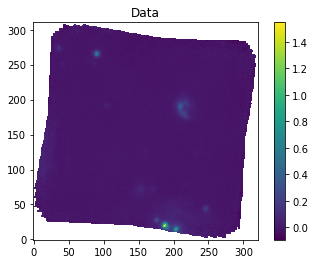

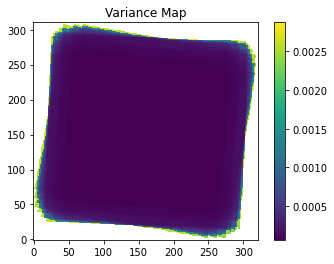

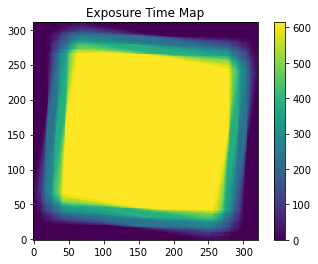

In [126]:
#take a quick look at the maps that were loaded in 
plt.figure()
plt.title('Data')
plt.imshow(data,origin='lower',interpolation='none')
plt.colorbar()
#plt.clim(0.0,0.1)
plt.show()

plt.figure()
plt.title('Variance Map')
plt.imshow(varmap,origin='lower',interpolation='none')
plt.colorbar()
plt.show()

plt.figure()
plt.title('Exposure Time Map')
plt.imshow(tmap,origin='lower',interpolation='none')
plt.colorbar()
plt.show()

#create pixel error map by taking sqrt of variance map
errormap=np.sqrt(varmap)

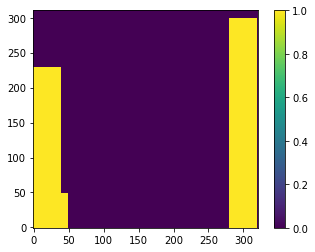

In [127]:
#create mask for edges of field where less integration time was collected
tmapnorm=tmap/np.max(tmap) #normalize the exposure time map
mask=np.where(tmapnorm<0.2,tmapnorm,0).astype('bool') #create mask for any locations with less than 50% of max exposure time -Can be modified as needed

#additional series of masks that can be applied when searching for sources in the segmentation map
mask2=np.zeros(np.shape(mask))  #mask 2 is applied to the first segmentation map instance for source detection
mask2[0:230,0:40]=1
mask2[0:50,0:50]=1
mask2[0:300,280:320]=1
#mask2[0:200,0:40]=1
mask3=np.zeros(np.shape(mask))  #mask 3 is applied to the deblended segmentation map for source detection - this may or may not be needed if the first 2 masks work ok
#mask3[0:330,0:70]=1

#plot any of the masks to verify they are configured as needed
plt.figure()
plt.imshow(mask2,origin='lower',interpolation='none')
plt.colorbar()
plt.show()

In [128]:
#create background model for image using median method
bkg_estimator = MedianBackground()
bkg_data = Background2D(data,(20, 20), filter_size=(3, 3),bkg_estimator=bkg_estimator,edge_method='pad') #smaller box?, 20x20, 25x25?
bkg_rms=bkg_data.background_rms
bkg=bkg_data.background 

#create background subtracted image
data_bkgsub = data - bkg

#set detection threshold for source finding based on modeled background rms
threshold = 3.0*bkg_rms

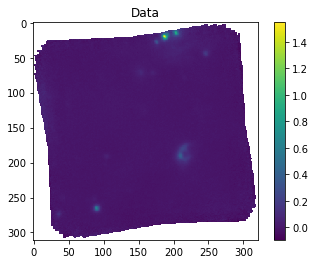

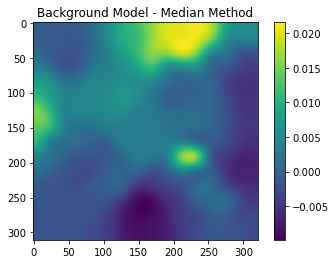

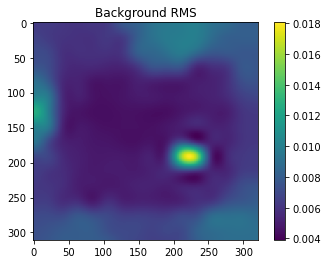

In [129]:
#take a look at data and bakground model images
plt.figure()
plt.title('Data')
plt.imshow(data,interpolation='none')
plt.colorbar()
plt.show()

plt.figure()
plt.title('Background Model - Median Method')
plt.imshow(bkg,interpolation='none')
plt.colorbar()
plt.show()

plt.figure()
plt.title('Background RMS')
plt.imshow(bkg_rms,interpolation='none')
plt.colorbar()
plt.show()

In [130]:
#do source detection. A 3x3 FWHM gaussian is used to smooth image prior to detection
sigma = 3.0 * gaussian_fwhm_to_sigma  # FWHM = 3.
kernel = Gaussian2DKernel(sigma, x_size=3, y_size=3)
kernel.normalize()
segm = detect_sources(data_bkgsub, threshold, mask=mask, npixels=5, filter_kernel=kernel)

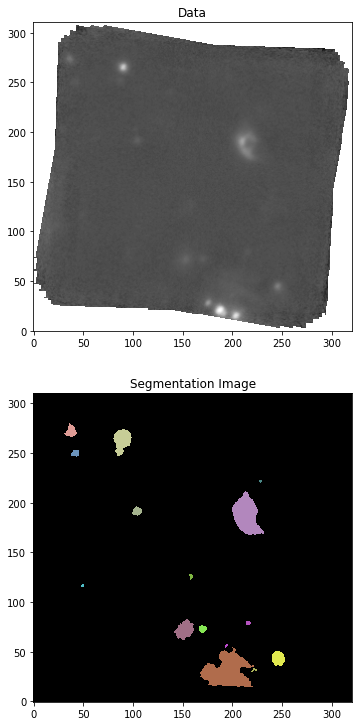

In [131]:
#removed labels that exist in masked region (mask2)
segm.remove_masked_labels(mask2.astype('bool'))

#make plot of segmentation image to show detected sources
norm = ImageNormalize(stretch=SqrtStretch())
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12.5))
ax1.imshow(data_bkgsub, origin='lower', cmap='Greys_r', norm=norm)
ax1.set_title('Data')
cmap = segm.make_cmap(seed=123)
ax2.imshow(segm, origin='lower', cmap=cmap, interpolation='nearest')
ax2.set_title('Segmentation Image')
plt.show()

In [132]:
#now lets look at building a catalog and associated table from the seg map
cat = SourceCatalog(data_bkgsub, segm,background=bkg,wcs=wcsmap) #can also take in error and bkg measurements - this is done later

#specify the columns that we want for our table
columns=['label','xcentroid','ycentroid','sky_centroid','background_centroid', 'background_mean','background_sum','area',
         'semimajor_sigma','semiminor_sigma','orientation', 'cxx','cxy','cyy','eccentricity','ellipticity','elongation',
         'fwhm','kron_flux','kron_fluxerr','kron_radius','segment_flux','segment_fluxerr']

#create table
tbl = cat.to_table(columns)

#display table below
tbl

label,xcentroid,ycentroid,sky_centroid,background_centroid,background_mean,background_sum,area,semimajor_sigma,semiminor_sigma,orientation,cxx,cxy,cyy,eccentricity,ellipticity,elongation,fwhm,kron_flux,kron_fluxerr,kron_radius,segment_flux,segment_fluxerr
,,,"deg,deg",,,,pix2,pix,pix,deg,1 / pix2,1 / pix2,1 / pix2,,,,pix,,,pix,,
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,192.26121664657464,23.638810898100658,"266.81028943323923,-28.446546157500656",0.0022708878190580246,0.018975772402295515,23.036587696386754,1214.0,10.090555182155537,7.307207167760753,-1.212561368908365,0.009825308981794734,0.00037688543165172444,0.01872425969192149,0.6896288016521878,0.27583695487012905,1.3809044892930993,20.744787185143103,nan,nan,nan,156.6764695068316,nan
3,221.66324538058373,31.44442840109807,"266.80315597538447,-28.44488018853489",-0.0011434635012828713,0.02115964728272189,0.2539157673926627,12.0,1.6372548934671818,0.8273929737453496,19.83698703373368,0.49830474378741174,-0.6944083061560161,1.335497073370577,0.8629122446172272,0.4946462050309124,1.9788116957965454,3.0545486827827206,6.11141560919477,nan,3.6310713870322497,0.4099337838380064,nan
4,246.3225022769262,43.469925638277836,"266.7971736409021,-28.44231381648041",-0.001590586394259137,0.008673809941847384,1.4051572105792762,162.0,3.1513768774191884,2.7764395822450596,-75.22273484589887,0.1278362376227909,0.014320059541956589,0.1025817296734405,0.47307102734216167,0.11897570800265012,1.1350424830317938,6.993417696073532,15.14360620379513,nan,2.193208388725063,10.421634154120326,nan
5,193.9350619912367,55.78357912449188,"266.80988406504196,-28.439688574794623",-0.0011615438096923842,0.009573080794391436,0.07658464635513149,8.0,1.11194934517249,0.5051623285538717,54.6178643093137,2.8760062646249223,-2.936263863806638,1.8514375123817297,0.8908470424798755,0.5456966356003304,2.2011723406922834,2.033629683435297,2.3999597730606705,nan,3.758219143352015,0.2187833172569481,nan
6,152.5163330873724,71.74844919997076,"266.81993279624874,-28.43628322121809",0.001703596382784651,0.007394497320526472,2.0260922658242535,274.0,4.687385574649138,3.583877385063932,52.87750813001989,0.0660757686736803,-0.03112788112960097,0.057293856153217707,0.6445298197790347,0.23542082724180546,1.3079090245062948,9.824957266942237,14.85183083889125,nan,2.008900566810916,9.473776766007369,nan
7,170.23963857599296,72.41085158309482,"266.81563305584797,-28.436141791611472",0.0007207339284345411,0.008133224532056919,0.3903947775387321,48.0,1.867646401023221,1.7539676126865384,11.0418675081612,0.28809613704771,-0.014424215642654007,0.3236476455275859,0.34355489728507177,0.06086740416944114,1.064812364558181,4.2662247738518175,3.411665676379043,nan,2.663698438232957,1.4649558397806133,nan
8,215.58928759388817,79.09116934990834,"266.8046312830831,-28.434715742550846",-0.002521159243747395,0.0008607106585179078,0.018074923828876065,21.0,1.3813241030851142,1.2045066805076328,63.28106562958317,0.6558692173961642,-0.1326616503926576,0.5574819552986234,0.4895161094004358,0.1280057462130496,1.146796547863863,3.0516926124068955,1.3186178643637638,nan,2.7623783841995886,0.44549876760628215,nan
10,49.17370645104335,116.84435718624732,"266.8450020151563,-28.426660754527628",0.005339991909849244,0.004237129721305636,0.03389703777044509,8.0,0.863793493394609,0.6237810044046296,45.638645174502365,1.968830489425632,-1.2294772362392805,1.9414173078149701,0.6917455184684661,0.27785864425391527,1.3847704359305721,1.7741361283064305,0.8232868982957724,nan,3.5726500827675065,0.1548503905871561,nan


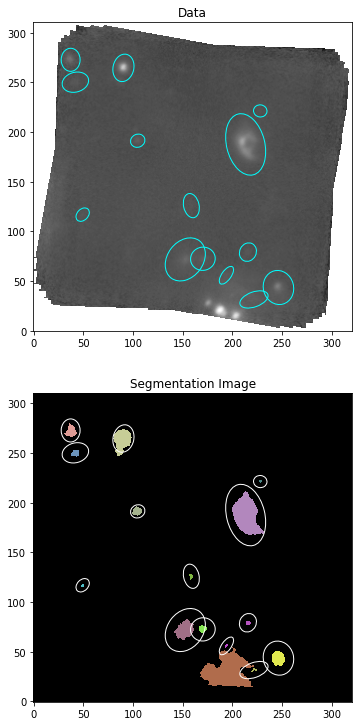

In [133]:
#overplot catalog sources on image - Note some sources may not have apertures plotted if kron aperture fails, but that's ok
norm = simple_norm(data, 'sqrt')
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12.5))
ax1.imshow(data, origin='lower', cmap='Greys_r', norm=norm)
ax1.set_title('Data')
cmap = segm.make_cmap(seed=123)
ax2.imshow(segm, origin='lower', cmap=cmap,interpolation='nearest')
ax2.set_title('Segmentation Image')
#try-except logic to catch any instances where kron aperture does something weird
for aperture in cat.kron_aperture:
    try:
        aperture.plot(axes=ax1, color='cyan', lw=1.)
        aperture.plot(axes=ax2, color='white', lw=1.)
    except:
        skip=1
plt.show()

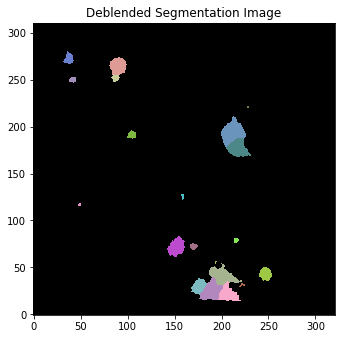

In [134]:
#lets take a look at deblending sources
segm_deblend = deblend_sources(data_bkgsub, segm, npixels=5,filter_kernel=kernel, nlevels=64,contrast=0.001)

#remove any sources that should be masked (mask3)
segm_deblend.remove_masked_labels(mask3.astype('bool'))

#plot the deblended image
plt.figure(figsize=(5.4, 8.5))
plt.imshow(segm_deblend, origin='lower', cmap=cmap, interpolation='nearest')
plt.title('Deblended Segmentation Image')
plt.show()

In [135]:
#now lets look at building a catalog and table from the deblended seg map
catde = SourceCatalog(data_bkgsub, segm_deblend,background=bkg,wcs=wcsmap)

#define which columns we want to have in the table
columns=['label','xcentroid','ycentroid','sky_centroid','background_centroid', 'background_mean','background_sum','area',
         'semimajor_sigma','semiminor_sigma','orientation', 'cxx','cxy','cyy','eccentricity','ellipticity','elongation',
         'fwhm','kron_flux','kron_fluxerr','kron_radius','segment_flux','segment_fluxerr']

#create table
tbl_deblend = catde.to_table(columns)

#display table
tbl_deblend

label,xcentroid,ycentroid,sky_centroid,background_centroid,background_mean,background_sum,area,semimajor_sigma,semiminor_sigma,orientation,cxx,cxy,cyy,eccentricity,ellipticity,elongation,fwhm,kron_flux,kron_fluxerr,kron_radius,segment_flux,segment_fluxerr
,,,"deg,deg",,,,pix2,pix,pix,deg,1 / pix2,1 / pix2,1 / pix2,,,,pix,,,pix,,
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,221.66324538058373,31.44442840109807,"266.80315597538447,-28.44488018853489",-0.0011434635012828713,0.02115964728272189,0.2539157673926627,12.0,1.6372548934671818,0.8273929737453496,19.83698703373368,0.49830474378741174,-0.6944083061560161,1.335497073370577,0.8629122446172272,0.4946462050309124,1.9788116957965454,3.0545486827827206,6.11141560919477,nan,3.6310713870322497,0.4099337838380064,nan
2,246.3225022769262,43.469925638277836,"266.7971736409021,-28.44231381648041",-0.001590586394259137,0.008673809941847384,1.4051572105792762,162.0,3.1513768774191884,2.7764395822450596,-75.22273484589887,0.1278362376227909,0.014320059541956589,0.1025817296734405,0.47307102734216167,0.11897570800265012,1.1350424830317938,6.993417696073532,15.14360620379513,nan,2.193208388725063,10.421634154120326,nan
3,193.9350619912367,55.78357912449188,"266.80988406504196,-28.439688574794623",-0.0011615438096923842,0.009573080794391436,0.07658464635513149,8.0,1.11194934517249,0.5051623285538717,54.6178643093137,2.8760062646249223,-2.936263863806638,1.8514375123817297,0.8908470424798755,0.5456966356003304,2.2011723406922834,2.033629683435297,2.3999597730606705,nan,3.758219143352015,0.2187833172569481,nan
4,152.5163330873724,71.74844919997076,"266.81993279624874,-28.43628322121809",0.001703596382784651,0.007394497320526472,2.0260922658242535,274.0,4.687385574649138,3.583877385063932,52.87750813001989,0.0660757686736803,-0.03112788112960097,0.057293856153217707,0.6445298197790347,0.23542082724180546,1.3079090245062948,9.824957266942237,14.85183083889125,nan,2.008900566810916,9.473776766007369,nan
5,170.23963857599296,72.41085158309482,"266.81563305584797,-28.436141791611472",0.0007207339284345411,0.008133224532056919,0.3903947775387321,48.0,1.867646401023221,1.7539676126865384,11.0418675081612,0.28809613704771,-0.014424215642654007,0.3236476455275859,0.34355489728507177,0.06086740416944114,1.064812364558181,4.2662247738518175,3.411665676379043,nan,2.663698438232957,1.4649558397806133,nan
6,215.58928759388817,79.09116934990834,"266.8046312830831,-28.434715742550846",-0.002521159243747395,0.0008607106585179078,0.018074923828876065,21.0,1.3813241030851142,1.2045066805076328,63.28106562958317,0.6558692173961642,-0.1326616503926576,0.5574819552986234,0.4895161094004358,0.1280057462130496,1.146796547863863,3.0516926124068955,1.3186178643637638,nan,2.7623783841995886,0.44549876760628215,nan
7,49.17370645104335,116.84435718624732,"266.8450020151563,-28.426660754527628",0.005339991909849244,0.004237129721305636,0.03389703777044509,8.0,0.863793493394609,0.6237810044046296,45.638645174502365,1.968830489425632,-1.2294772362392805,1.9414173078149701,0.6917455184684661,0.27785864425391527,1.3847704359305721,1.7741361283064305,0.8232868982957724,nan,3.5726500827675065,0.1548503905871561,nan
8,158.59459453906004,125.90572011325133,"266.81845851750097,-28.424729645968025",0.0033869379308541945,0.003148402864968755,0.05037444583950008,16.0,1.4412511546045979,0.9073957915863837,-77.30963110988212,1.1791450164757693,0.314233505437875,0.5167961977520215,0.7769284152106372,0.3704110566105152,1.5883379314388095,2.835858468250376,1.8777665258256777,nan,3.4347569267842424,0.2868680075195673,nan


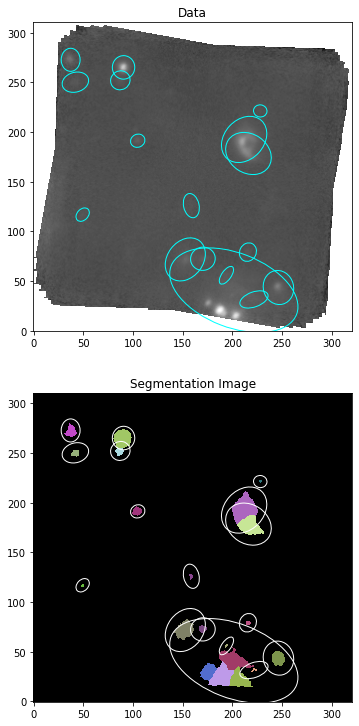

In [136]:
#overplot catalog sources on image - Note some sources may not have apertures plotted if kron aperture fails, but that's ok
norm = simple_norm(data, 'sqrt')
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12.5))
ax1.imshow(data, origin='lower', cmap='Greys_r', norm=norm)
ax1.set_title('Data')
cmap = segm_deblend.make_cmap(seed=123)
ax2.imshow(segm_deblend, origin='lower', cmap=cmap,interpolation='nearest')
ax2.set_title('Segmentation Image')
#try-except logic to catch any instances where kron aperture does something weird
for aperture in catde.kron_aperture:
    try:
        aperture.plot(axes=ax1, color='cyan', lw=1.)
        aperture.plot(axes=ax2, color='white', lw=1.)
    except:
        skip=1
plt.show()

In [137]:
#what if we wanted to include errors? - Not completely sure this is implemented correctly for our observations, but we'll use it for now...
calfactor = header['CALFCTR'] # units are (Me/sec/Jy)
gainfactor=tmap*calfactor*1e6 #gain in electrons/Jy
#errormap=calc_total_error(data,bkg,gainfactor) #use the varmap instead. Its probably more appropriate for our data type. 

#now lets look at building a catalog from the seg map
catwerr = SourceCatalog(data_bkgsub, segm_deblend,background=bkg,error=errormap,wcs=wcsmap)
columns=['label','xcentroid','ycentroid','sky_centroid','background_centroid', 'background_mean','background_sum','background','area',
         'semimajor_sigma','semiminor_sigma','orientation', 'cxx','cxy','cyy','eccentricity','ellipticity','elongation',
         'fwhm','kron_flux','kron_fluxerr','kron_radius','segment_flux','segment_fluxerr']#,'kron_aperture']
tbl2 = catwerr.to_table(columns)

In [138]:
#calculate statistics for background cutouts in table
segbkg_median=[]
segbkg_mean=[]
segbkg_std=[]

#loop through each cutout and use sigma_cliped_stats to get mean, median, and std
for i in range (0,len(tbl2['background'])):
    bkgdata=tbl2['background'][i]
    meansc, median_sigclip, stdsc = sigma_clipped_stats(bkgdata)
    segbkg_median.append(median_sigclip)
    segbkg_mean.append(meansc)
    segbkg_std.append(stdsc)

#add the above calculated information to our table
tbl2['segbkg_mean_sc']=segbkg_mean
tbl2['segbkg_median_sc']=segbkg_median
tbl2['segbkg_std_sc']=segbkg_std  

#remove the 2d background array to tidy up the table
tbl2.remove_column('background')

In [139]:
#calculate noise stats
#sky noise from background
skynoise=np.sqrt(tbl2['segbkg_median_sc']*tbl2['area']/u.pix**2)
#replace any nan values with zero
sna=np.array(skynoise)
masknan=np.isnan(sna)
sna[masknan]=0.0
skynoise=sna**2

#shot noise from the source
sourcenoise=tbl2['segment_flux']

#thermal noise from camera (from error map)
thermalnoise=tbl2['segment_fluxerr']

#total noise
#totalnoise=np.sqrt(sourcenoise+thermalnoise+skynoise) #includes all noise sources
totalnoise=np.sqrt(thermalnoise+skynoise) #no shot noise -> For some reason this seems to work much better for the apertures. Need to think about why this is a bit more...

#calculate SNR for the segments
tbl2['segmentSNR']=tbl2['segment_flux']/ totalnoise 

#display table
tbl2

C:\Users\mhankins1\Anaconda3\lib\site-packages\astropy\units\quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


label,xcentroid,ycentroid,sky_centroid,background_centroid,background_mean,background_sum,area,semimajor_sigma,semiminor_sigma,orientation,cxx,cxy,cyy,eccentricity,ellipticity,elongation,fwhm,kron_flux,kron_fluxerr,kron_radius,segment_flux,segment_fluxerr,segbkg_mean_sc,segbkg_median_sc,segbkg_std_sc,segmentSNR
,,,"deg,deg",,,,pix2,pix,pix,deg,1 / pix2,1 / pix2,1 / pix2,,,,pix,,,pix,,,,,,
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float64,float64,float64,float64
1,221.66324538058373,31.44442840109807,"266.80315597538447,-28.44488018853489",-0.0011434635012828713,0.02115964728272189,0.2539157673926627,12.0,1.6372548934671818,0.8273929737453496,19.83698703373368,0.49830474378741174,-0.6944083061560161,1.335497073370577,0.8629122446172272,0.4946462050309124,1.9788116957965454,3.0545486827827206,6.11141560919477,0.20622375053353698,3.6310713870322497,0.4099337838380064,0.037728157,0.021175518231638744,0.0211939805322127,0.00017232132507256163,0.7585438679899353
2,246.3225022769262,43.469925638277836,"266.7971736409021,-28.44231381648041",-0.001590586394259137,0.008673809941847384,1.4051572105792762,162.0,3.1513768774191884,2.7764395822450596,-75.22273484589887,0.1278362376227909,0.014320059541956589,0.1025817296734405,0.47307102734216167,0.11897570800265012,1.1350424830317938,6.993417696073532,15.14360620379513,0.2603395939871211,2.193208388725063,10.421634154120326,0.11076626,0.008780793124800186,0.008766015154365312,0.0026754698220144636,8.423022950053833
3,193.9350619912367,55.78357912449188,"266.80988406504196,-28.439688574794623",-0.0011615438096923842,0.009573080794391436,0.07658464635513149,8.0,1.11194934517249,0.5051623285538717,54.6178643093137,2.8760062646249223,-2.936263863806638,1.8514375123817297,0.8908470424798755,0.5456966356003304,2.2011723406922834,2.033629683435297,2.3999597730606705,0.10292176330983308,3.758219143352015,0.2187833172569481,0.023310922,0.009731567203302949,0.009735041701026358,0.0006783164146739426,0.6877691797700004
4,152.5163330873724,71.74844919997076,"266.81993279624874,-28.43628322121809",0.001703596382784651,0.007394497320526472,2.0260922658242535,274.0,4.687385574649138,3.583877385063932,52.87750813001989,0.0660757686736803,-0.03112788112960097,0.057293856153217707,0.6445298197790347,0.23542082724180546,1.3079090245062948,9.824957266942237,14.85183083889125,0.2996986002289828,2.008900566810916,9.473776766007369,0.13607785,0.007312161444967735,0.007038500132436349,0.0013456214349606124,6.593292724447799
5,170.23963857599296,72.41085158309482,"266.81563305584797,-28.436141791611472",0.0007207339284345411,0.008133224532056919,0.3903947775387321,48.0,1.867646401023221,1.7539676126865384,11.0418675081612,0.28809613704771,-0.014424215642654007,0.3236476455275859,0.34355489728507177,0.06086740416944114,1.064812364558181,4.2662247738518175,3.411665676379043,0.17560458398762527,2.663698438232957,1.4649558397806133,0.056975342,0.00811225451628092,0.008106707889951239,0.0007967895751758602,2.1933590238149594
6,215.58928759388817,79.09116934990834,"266.8046312830831,-28.434715742550846",-0.002521159243747395,0.0008607106585179078,0.018074923828876065,21.0,1.3813241030851142,1.2045066805076328,63.28106562958317,0.6558692173961642,-0.1326616503926576,0.5574819552986234,0.4895161094004358,0.1280057462130496,1.146796547863863,3.0516926124068955,1.3186178643637638,0.13135360824456646,2.7623783841995886,0.44549876760628215,0.038117915,0.0008901154863077033,0.0008695810499655309,0.0001970837158125079,1.8762355927653336
7,49.17370645104335,116.84435718624732,"266.8450020151563,-28.426660754527628",0.005339991909849244,0.004237129721305636,0.03389703777044509,8.0,0.863793493394609,0.6237810044046296,45.638645174502365,1.968830489425632,-1.2294772362392805,1.9414173078149701,0.6917455184684661,0.27785864425391527,1.3847704359305721,1.7741361283064305,0.8232868982957724,0.09832

In [140]:
#now lets look at performing some aperture photometry on the data.... Lets get the source centroids from the segmentaion map table
sourcecoords=tbl2['sky_centroid']

In [141]:
#first let's do some simple annulus extractions...   
radii = [2,4,6,8,10] #define aperture radii & construct apertures (line below)
apertures =[SkyCircularAperture(sourcecoords, r=r*u.arcsec) for r in radii] # for pixels: r=r*u.arcsec*0.786

#do aperture photometry on data using defined apertures 
phot_table = aperture_photometry(data_bkgsub, apertures,wcs=wcsmap,error=errormap,method='exact')

#display phot table
phot_table

id,xcenter,ycenter,sky_center,aperture_sum_0,aperture_sum_err_0,aperture_sum_1,aperture_sum_err_1,aperture_sum_2,aperture_sum_err_2,aperture_sum_3,aperture_sum_err_3,aperture_sum_4,aperture_sum_err_4
,pix,pix,"deg,deg",,,,,,,,,,
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,221.66324538069526,31.444428401072884,"266.80315597538447,-28.44488018853489",0.6256186469396319,0.050475145549997914,2.212608002783176,0.10162253877097975,4.2236158120887675,0.15308878662967876,6.8909827761009375,0.2050611868453262,10.658999562284704,0.25724416740827466
2,246.32250227702588,43.46992563820589,"266.7971736409021,-28.44231381648041",3.010829615855717,0.03926994981334599,7.8611861823197025,0.0792198090407993,10.922873761351054,0.11999479974393538,12.696385493715749,0.16152578837796694,13.846238599839438,0.20412382908692125
3,193.93506199115816,55.783579124560376,"266.80988406504196,-28.439688574794623",0.520050469944815,0.038051679067230317,1.7021489566204524,0.07609212052891905,3.5160122175597515,0.11412832058553529,6.03655348216572,0.15219389399509836,8.955017652722242,0.19149406170772132
4,152.5163330873484,71.74844919989692,"266.81993279624874,-28.43628322121809",1.536248021383284,0.03795031950847932,4.699264884652908,0.07590394551112987,7.756627030873232,0.11384437330899867,10.382609775019441,0.15178602207369826,12.352607566546371,0.18970243979688134
5,170.23963857607544,72.41085158311971,"266.81563305584797,-28.436141791611472",0.8125892656786873,0.03796503343092721,1.9833293093978823,0.075904910106727,2.818136831157856,0.11383319751241222,3.543159315564345,0.15176878852488238,4.534786962041239,0.18969109488562474
6,215.5892875938603,79.09116934985956,"266.8046312830831,-28.434715742550846",0.4453382238984113,0.03839261121115963,0.9846149910896774,0.07681076839185617,1.2550643461260118,0.11520873990532382,1.374848991436981,0.15358148114896958,1.4736985547794734,0.19193585048243006
7,49.173706451111656,116.84435718618944,"266.8450020151563,-28.426660754527628",0.3088753947701338,0.038303303082130306,0.7129002588312643,0.07745033472566878,0.9103660583898183,0.11799767196450318,1.0264821428620423,0.15963256501773662,0.9548386977926626,0.2023097565960518
8,158.59459453913107,125.90572011318287,"266.81845851750097,-28.424729645968025",0.3298185913966741,0.03718384678533612,0.945307991618704,0.07433038688383564,1.521496070422463,0.11149931902244394,1.9803436561711116,0.14868491565203312,2.4929116215936777,0.1858695548629769


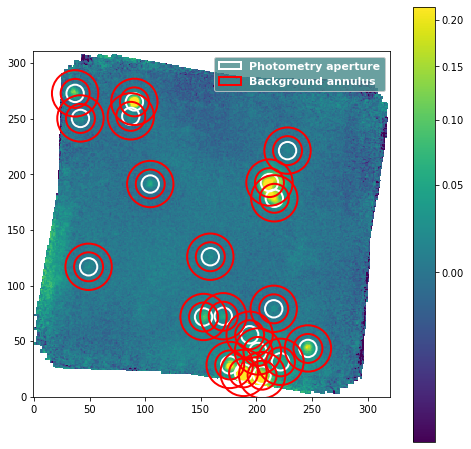

In [142]:
#now try photometry with local background subtraction
aperture2 =SkyCircularAperture(sourcecoords, r=6*u.arcsec) #define aperture
annulus_aperture = SkyCircularAnnulus(sourcecoords, r_in=10*u.arcsec, r_out=16*u.arcsec) #define annulus

#convert to pixel coords for plotting
pix_aperture = aperture2.to_pixel(wcsmap)
pix_annulus_aperture = annulus_aperture.to_pixel(wcsmap)


#show figure with apertures overlayed
plt.figure(figsize=(8,8))
norm = simple_norm(data, 'sqrt', percent=99)
plt.imshow(data, norm=norm, interpolation='nearest',origin='lower')
plt.colorbar()
#plt.xlim(40, 140)
#plt.ylim(50, 125)

ap_patches = pix_aperture.plot(color='white', lw=2,
                           label='Photometry aperture')
ann_patches = pix_annulus_aperture.plot(color='red', lw=2,
                                    label='Background annulus')
handles = (ap_patches[0], ann_patches[0])
plt.legend(loc='best', facecolor='#458989', labelcolor='white',
           handles=handles, prop={'weight': 'bold', 'size': 11})
plt.show()

In [143]:
#now lets do robust statistics on the background annuli

#create lists to store information for later
bkg_median=[]
bkg_mean=[]
bkg_std=[]
appmasks=[]

#create mask array for the annuli
annulus_masks = pix_annulus_aperture.to_mask(method='exact')

#for each of the annuli loop through and calculate stats using sigma cliped stats
for mask in annulus_masks:
    annulus_data = mask.multiply(data_bkgsub)
    
    #this is a bit of debugging to handle if the mask array is the wrong shape
    if np.shape(mask.data)[0]==41:
        maskdata=mask.data[:-1,:]
    else:
        maskdata=mask.data
        
    #do statistics
    annulus_data_1d = annulus_data[maskdata > 0]
    meansc, median_sigclip, stdsc = sigma_clipped_stats(annulus_data_1d)
    bkg_median.append(median_sigclip)
    bkg_mean.append(meansc)
    bkg_std.append(stdsc)
    appmasks.append(mask.data)

#store values in numpy arrays
bkg_median = np.array(bkg_median)
bkg_mean = np.array(bkg_mean)
bkg_std = np.array(bkg_std)

In [144]:
#do aperture photometry
phot_table2 = aperture_photometry(data_bkgsub, aperture2,wcs=wcsmap,error=errormap,method='exact') #

#add columns for background information and also background subtracted apertures
phot_table2['ann_bkg_med'] = bkg_median
phot_table2['ann_bkg_mean'] = bkg_mean 
phot_table2['aper_sum_bkgsub_6as'] = (phot_table2['aperture_sum']/pix_aperture.area - phot_table2['ann_bkg_med'])* pix_aperture.area 
phot_table2['aper_sum_bkgsub_err_6as'] = phot_table2['aperture_sum_err'] # should this be modified by bkgsub in some way?
#not sure if the above is right for the error array...

#calculate sky noise for 6 pixel aperture
skynoise=np.sqrt(phot_table2['ann_bkg_med']*pix_aperture.area)
sna=np.array(skynoise)
masknan=np.isnan(sna)
sna[masknan]=0.0
skynoise=sna**2

#store per pix sky noise for later
phot_table2['skynoise_pix']=skynoise/pix_aperture.area

#shot noise from the source
sourcenoise=phot_table2['aper_sum_bkgsub_6as']

#thermal noise from camera (from error map)
thermalnoise=phot_table2['aperture_sum_err']

#compute total noise 
#totalnoise=np.sqrt(sourcenoise+thermalnoise+skynoise) #all noise sources
#totalnoise=np.sqrt(thermalnoise+skynoise) # no shot noise -> For some reason this seems to give more 'reasonable' values. Need to think about why this is a bit more...
totalnoise=np.sqrt((thermalnoise+skynoise)*(1+pix_aperture.area/pix_annulus_aperture.area)) #modified to account for pixel stats

#SNR calc for 6 pixel aperture
phot_table2['aper_snr_6as']=phot_table2['aper_sum_bkgsub_6as']/totalnoise

#display new table
phot_table2

<ipython-input-144-d3b3f743c6c3>:12: RuntimeWarning: invalid value encountered in sqrt
  skynoise=np.sqrt(phot_table2['ann_bkg_med']*pix_aperture.area)


id,xcenter,ycenter,sky_center,aperture_sum,aperture_sum_err,ann_bkg_med,ann_bkg_mean,aper_sum_bkgsub_6as,aper_sum_bkgsub_err_6as,skynoise_pix,aper_snr_6as
,pix,pix,"deg,deg",,,,,,,,
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64
1,221.66324538069526,31.444428401072884,"266.80315597538447,-28.44488018853489",4.2236158120887675,0.15308878662967876,0.012402100981940098,0.017079388368820305,1.8455427737919292,0.15308878662967876,0.0124021009819401,1.0456247250871022
2,246.32250227702588,43.46992563820589,"266.7971736409021,-28.44231381648041",10.922873761351054,0.11999479974393538,0.0017293615587461461,0.002517160169752145,10.591272841288406,0.11999479974393538,0.0017293615587461464,14.206429233372694
3,193.93506199115816,55.783579124560376,"266.80988406504196,-28.439688574794623",3.5160122175597515,0.11412832058553529,0.0060815393038698195,0.010363600213137163,2.3498916811332733,0.11412832058553529,0.006081539303869819,1.8720279570814786
4,152.5163330873484,71.74844919989692,"266.81993279624874,-28.43628322121809",7.756627030873232,0.11384437330899867,0.0020900077878761108,0.0026809073155913054,7.355873063669113,0.11384437330899867,0.0020900077878761103,9.24297376593995
5,170.23963857607544,72.41085158311971,"266.81563305584797,-28.436141791611472",2.818136831157856,0.11383319751241222,0.0009111901193549585,0.001707022090144185,2.643418317032233,0.11383319751241222,0.0009111901193549585,4.435736632639929
6,215.5892875938603,79.09116934985956,"266.8046312830831,-28.434715742550846",1.2550643461260118,0.11520873990532382,-8.60247729526556e-06,1.056256871663692e-05,1.2567138504598518,0.11520873990532382,0.0,3.3373778028074503
7,49.173706451111656,116.84435718618944,"266.8450020151563,-28.426660754527628",0.9103660583898183,0.11799767196450318,8.87831430025821e-05,0.0002528499716256965,0.8933421042277659,0.11799767196450318,8.87831430025821e-05,2.191431101698578
8,158.59459453913107,125.90572011318287,"266.81845851750097,-28.424729645968025",1.521496070422463,0.11149931902244394,-0.00016062397094381245,-0.0003050667225983358,1.5522953305770035,0.11149931902244394,0.0,4.190346424315353


In [145]:
#fix id keyword in tbl2 so these can be merged with the phot table results
try:
    tbl2.rename_column('label', 'id')
except:
    print('Do nothing because keyword is already changed.')

In [146]:
#merge the two photometry tables
merged_table = join(phot_table, phot_table2, keys='id')

#merge the segmentation map table with the combined phot table
merged_table_2 = join(tbl2,merged_table, keys='id')

#drop repeat columns
merged_table_2.remove_columns(['xcenter_1','ycenter_1','xcenter_2','ycenter_2','sky_center_1','sky_center_2','aperture_sum','aperture_sum_err'])

#rename some columns to avoid possible confusion
merged_table_2.rename_column('aperture_sum_0', 'aperture_sum_2as')
merged_table_2.rename_column('aperture_sum_err_0', 'aperture_sum_err_2as')
merged_table_2.rename_column('aperture_sum_1', 'aperture_sum_4as')
merged_table_2.rename_column('aperture_sum_err_1', 'aperture_sum_err_4as')
merged_table_2.rename_column('aperture_sum_2', 'aperture_sum_6as')
merged_table_2.rename_column('aperture_sum_err_2', 'aperture_sum_err_6as')
merged_table_2.rename_column('aperture_sum_3', 'aperture_sum_8as')
merged_table_2.rename_column('aperture_sum_err_3', 'aperture_sum_err_8as')
merged_table_2.rename_column('aperture_sum_4', 'aperture_sum_10as')
merged_table_2.rename_column('aperture_sum_err_4', 'aperture_sum_err_10as')


#compute area for the different size apertures 
ap2area=pix_aperture.area*(2./6.)**2
ap4area=pix_aperture.area*(4./6.)**2
#ap6area=pix_aperture.area*(6./6.)**2
ap8area=pix_aperture.area*(8./6.)**2
ap10area=pix_aperture.area*(10./6.)**2


#calculate local bkg subtracted photometry for the other apertures 
merged_table_2['aper_sum_bkgsub_2as']=(merged_table_2['aperture_sum_2as']/ap2area-merged_table_2['ann_bkg_med'])*ap2area
merged_table_2['aper_sum_bkgsub_4as']=(merged_table_2['aperture_sum_4as']/ap4area-merged_table_2['ann_bkg_med'])*ap4area
#merged_table_2['aper_sum_bkgsub_6as']=(merged_table_2['aperture_sum_6as']/ap6area-merged_table_2['ann_bkg_med'])*ap6area
merged_table_2['aper_sum_bkgsub_8as']=(merged_table_2['aperture_sum_8as']/ap8area-merged_table_2['ann_bkg_med'])*ap8area
merged_table_2['aper_sum_bkgsub_10as']=(merged_table_2['aperture_sum_10as']/ap10area-merged_table_2['ann_bkg_med'])*ap10area

#calculate snr for each aperture
merged_table_2['aper_snr_2as']=merged_table_2['aper_sum_bkgsub_2as']/np.sqrt((merged_table_2['aperture_sum_err_2as']+merged_table_2['skynoise_pix']*ap2area)*(1+ap2area/pix_annulus_aperture.area))
merged_table_2['aper_snr_4as']=merged_table_2['aper_sum_bkgsub_4as']/np.sqrt((merged_table_2['aperture_sum_err_4as']+merged_table_2['skynoise_pix']*ap4area)*(1+ap4area/pix_annulus_aperture.area))
#merged_table_2['aper_snr_6as']=merged_table_2['aper_sum_bkgsub_6as']/np.sqrt((merged_table_2['aperture_sum_err_6as']+merged_table_2['skynoise_pix']*ap6area)*(1+ap6area/pix_annulus_aperture.area))
merged_table_2['aper_snr_8as']=merged_table_2['aper_sum_bkgsub_8as']/np.sqrt((merged_table_2['aperture_sum_err_8as']+merged_table_2['skynoise_pix']*ap8area)*(1+ap8area/pix_annulus_aperture.area))
merged_table_2['aper_snr_10as']=merged_table_2['aper_sum_bkgsub_10as']/np.sqrt((merged_table_2['aperture_sum_err_10as']+merged_table_2['skynoise_pix']*ap10area)*(1+ap10area/pix_annulus_aperture.area))

#calculate max snr for all apertures
snr_values=np.array(merged_table_2['aper_snr_2as','aper_snr_4as','aper_snr_6as','aper_snr_8as','aper_snr_10as'])
snr_values.dtype=np.float
snr_values=np.reshape(snr_values, (-1,5))
maxsnr=np.nanmax(snr_values,axis=1)
merged_table_2['aper_snr_max']=maxsnr

#add additonal information for wavelength and which field 
merged_table_2['Field']='C7'+field
merged_table_2['wv']=wavelength

#display table
merged_table_2

id,xcentroid,ycentroid,sky_centroid,background_centroid,background_mean,background_sum,area,semimajor_sigma,semiminor_sigma,orientation,cxx,cxy,cyy,eccentricity,ellipticity,elongation,fwhm,kron_flux,kron_fluxerr,kron_radius,segment_flux,segment_fluxerr,segbkg_mean_sc,segbkg_median_sc,segbkg_std_sc,segmentSNR,aperture_sum_2as,aperture_sum_err_2as,aperture_sum_4as,aperture_sum_err_4as,aperture_sum_6as,aperture_sum_err_6as,aperture_sum_8as,aperture_sum_err_8as,aperture_sum_10as,aperture_sum_err_10as,ann_bkg_med,ann_bkg_mean,aper_sum_bkgsub_6as,aper_sum_bkgsub_err_6as,skynoise_pix,aper_snr_6as,aper_sum_bkgsub_2as,aper_sum_bkgsub_4as,aper_sum_bkgsub_8as,aper_sum_bkgsub_10as,aper_snr_2as,aper_snr_4as,aper_snr_8as,aper_snr_10as,aper_snr_max,Field,wv
,,,"deg,deg",,,,pix2,pix,pix,deg,1 / pix2,1 / pix2,1 / pix2,,,,pix,,,pix,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str8,float64
1,221.66324538058373,31.44442840109807,"266.80315597538447,-28.44488018853489",-0.0011434635012828713,0.02115964728272189,0.2539157673926627,12.0,1.6372548934671818,0.8273929737453496,19.83698703373368,0.49830474378741174,-0.6944083061560161,1.335497073370577,0.8629122446172272,0.4946462050309124,1.9788116957965454,3.0545486827827206,6.11141560919477,0.20622375053353698,3.6310713870322497,0.4099337838380064,0.037728157,0.021175518231638744,0.0211939805322127,0.00017232132507256163,0.7585438679899353,0.6256186469396319,0.050475145549997914,2.212608002783176,0.10162253877097975,4.2236158120887675,0.15308878662967876,6.8909827761009375,0.2050611868453262,10.658999562284704,0.25724416740827466,0.012402100981940098,0.017079388368820305,1.8455427737919292,0.15308878662967876,0.0124021009819401,1.0456247250871022,0.36138830935109434,1.1556866524290257,2.6632973746843365,4.053241122571263,0.6360983255149819,1.022543818714143,1.0652073823894774,1.2077795579589772,1.2077795579589772,C7Field9,25.2
2,246.3225022769262,43.469925638277836,"266.7971736409021,-28.44231381648041",-0.001590586394259137,0.008673809941847384,1.4051572105792762,162.0,3.1513768774191884,2.7764395822450596,-75.22273484589887,0.1278362376227909,0.014320059541956589,0.1025817296734405,0.47307102734216167,0.11897570800265012,1.1350424830317938,6.993417696073532,15.14360620379513,0.2603395939871211,2.193208388725063,10.421634154120326,0.11076626,0.008780793124800186,0.008766015154365312,0.0026754698220144636,8.423022950053833,3.010829615855717,0.03926994981334599,7.8611861823197025,0.0792198090407993,10.922873761351054,0.11999479974393538,12.696385493715749,0.16152578837796694,13.846238599839438,0.20412382908692125,0.0017293615587461461,0.002517160169752145,10.591272841288406,0.11999479974393538,0.0017293615587461464,14.206429233372694,2.9739850691820893,7.713807995625193,12.106872746937709,12.92512493299875,10.644062164282706,15.4325917729837,11.763913594876406,9.511630446066105,15.4325917729837,C7Field9,25.2
3,193.9350619912367,55.78357912449188,"266.80988406504196,-28.439688574794623",-0.0011615438096923842,0.009573080794391436,0.07658464635513149,8.0,1.11194934517249,0.5051623285538717,54.6178643093137,2.8760062646249223,-2.936263863806638,1.8514375123817297,0.8908470424798755,0.5456966356003304,2.2011723406922834,2.033629683435297,2.3999597730606705,0.10292176330983308,3.758219143352015,0.2187833172569481,0.023310922,0.009731567203302949,0.009735041701026358,0.0006783164146739426,0.6877691797700004,0.520050469944815,0.038051679067230317,1.7021489566204524,0.07609212052891905,3.5160122175597515,0.11412832058553529,6.03655348216572,0.15219389399509836,8.955017652722242,0.19149406170772132,0.0060815393038698

In [147]:
#write out the resulting table to file
ascii.write(merged_table_2, field+'_25um_cat.dat', overwrite=True)

In [148]:
#add simple quality cuts to saved sources
snrcut=merged_table_2['aper_snr_max']>=3.0 #max snr in all computed apertures must be gtreq to 3.0
fwhmcut=merged_table_2['fwhm']>=2.5*u.pix #fwhm measures must be greater than 2.5 pixels (~1.9")
keepconditions=(snrcut&fwhmcut) #conditions to keep a source
mtcut=merged_table_2[keepconditions] #apply conditions

#display new table with simple quality cuts
mtcut

id,xcentroid,ycentroid,sky_centroid,background_centroid,background_mean,background_sum,area,semimajor_sigma,semiminor_sigma,orientation,cxx,cxy,cyy,eccentricity,ellipticity,elongation,fwhm,kron_flux,kron_fluxerr,kron_radius,segment_flux,segment_fluxerr,segbkg_mean_sc,segbkg_median_sc,segbkg_std_sc,segmentSNR,aperture_sum_2as,aperture_sum_err_2as,aperture_sum_4as,aperture_sum_err_4as,aperture_sum_6as,aperture_sum_err_6as,aperture_sum_8as,aperture_sum_err_8as,aperture_sum_10as,aperture_sum_err_10as,ann_bkg_med,ann_bkg_mean,aper_sum_bkgsub_6as,aper_sum_bkgsub_err_6as,skynoise_pix,aper_snr_6as,aper_sum_bkgsub_2as,aper_sum_bkgsub_4as,aper_sum_bkgsub_8as,aper_sum_bkgsub_10as,aper_snr_2as,aper_snr_4as,aper_snr_8as,aper_snr_10as,aper_snr_max,Field,wv
,,,"deg,deg",,,,pix2,pix,pix,deg,1 / pix2,1 / pix2,1 / pix2,,,,pix,,,pix,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str8,float64
2,246.3225022769262,43.469925638277836,"266.7971736409021,-28.44231381648041",-0.001590586394259137,0.008673809941847384,1.4051572105792762,162.0,3.1513768774191884,2.7764395822450596,-75.22273484589887,0.1278362376227909,0.014320059541956589,0.1025817296734405,0.47307102734216167,0.11897570800265012,1.1350424830317938,6.993417696073532,15.14360620379513,0.2603395939871211,2.193208388725063,10.421634154120326,0.11076626,0.008780793124800186,0.008766015154365312,0.0026754698220144636,8.423022950053833,3.010829615855717,0.03926994981334599,7.8611861823197025,0.0792198090407993,10.922873761351054,0.11999479974393538,12.696385493715749,0.16152578837796694,13.846238599839438,0.20412382908692125,0.0017293615587461461,0.002517160169752145,10.591272841288406,0.11999479974393538,0.0017293615587461464,14.206429233372694,2.9739850691820893,7.713807995625193,12.106872746937709,12.92512493299875,10.644062164282706,15.4325917729837,11.763913594876406,9.511630446066105,15.4325917729837,C7Field9,25.2
4,152.5163330873724,71.74844919997076,"266.81993279624874,-28.43628322121809",0.001703596382784651,0.007394497320526472,2.0260922658242535,274.0,4.687385574649138,3.583877385063932,52.87750813001989,0.0660757686736803,-0.03112788112960097,0.057293856153217707,0.6445298197790347,0.23542082724180546,1.3079090245062948,9.824957266942237,14.85183083889125,0.2996986002289828,2.008900566810916,9.473776766007369,0.13607785,0.007312161444967735,0.007038500132436349,0.0013456214349606124,6.593292724447799,1.536248021383284,0.03795031950847932,4.699264884652908,0.07590394551112987,7.756627030873232,0.11384437330899867,10.382609775019441,0.15178602207369826,12.352607566546371,0.18970243979688134,0.0020900077878761108,0.0026809073155913054,7.355873063669113,0.11384437330899867,0.0020900077878761103,9.24297376593995,1.4917198028050487,4.521152010339966,9.670158277767674,11.239402102090486,5.128839228687744,8.543109002125178,8.759271403419058,7.686500610048733,9.24297376593995,C7Field9,25.2
5,170.23963857599296,72.41085158309482,"266.81563305584797,-28.436141791611472",0.0007207339284345411,0.008133224532056919,0.3903947775387321,48.0,1.867646401023221,1.7539676126865384,11.0418675081612,0.28809613704771,-0.014424215642654007,0.3236476455275859,0.34355489728507177,0.06086740416944114,1.064812364558181,4.2662247738518175,3.411665676379043,0.17560458398762527,2.663698438232957,1.4649558397806133,0.056975342,0.00811225451628092,0.008106707889951239,0.0007967895751758602,2.1933590238149594,0.8125892656786873,0.03796503343092721,1.9833293093978823,0.075904910106727,2.818136831157856,0.11383319751241222,3.543159315564345,0.15176878852488238,4.534786962041239,0.18969109488562474,0.0009111901193549585,0.0017

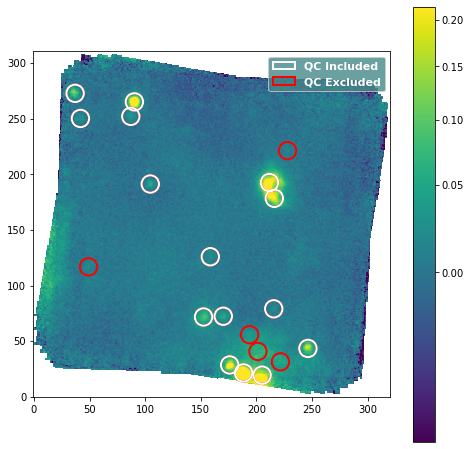

In [149]:
#now let's examine which sources didn't pass the cuts - overplot on the image to see if it looks first order reasonable

#get source coordinates for the snr cut table
cutsc=mtcut['sky_centroid'] 

#Compare which sources are included/excluded
source_aperture =SkyCircularAperture(cutsc, r=6*u.arcsec)

#convert to pixel coords for plotting
pix_aperture_source = source_aperture.to_pixel(wcsmap)


#show figure with apertures overlayed
plt.figure(figsize=(8,8))
norm = simple_norm(data, 'sqrt', percent=99)
plt.imshow(data, norm=norm, interpolation='nearest',origin='lower')
plt.colorbar()
#plt.xlim(40, 140)
#plt.ylim(50, 125)


ap_patches = pix_aperture.plot(color='red', lw=2,
                           label='QC Excluded')
ap_patches_new = pix_aperture_source.plot(color='white', lw=2,
                           label='QC Included')

handles = (ap_patches_new[0],ap_patches[0])
plt.legend(loc='best', facecolor='#458989', labelcolor='white',
          handles=handles, prop={'weight': 'bold', 'size': 11})
plt.show()

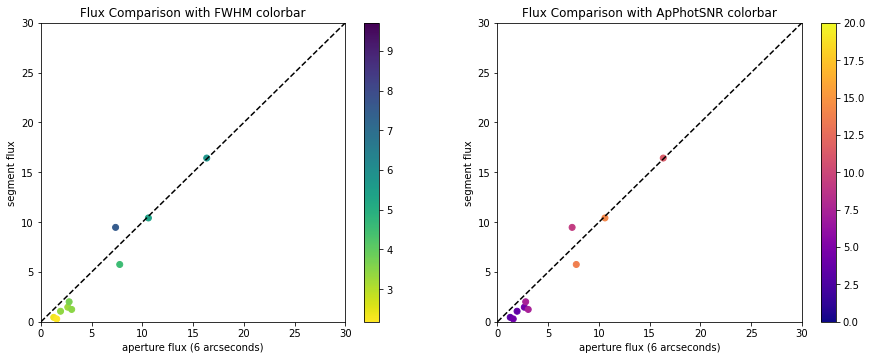

In [150]:
#a few diagnostic plots to examine segment and aperture fluxes
fig, (ax1,ax2) = plt.subplots(1, 2,figsize=(15,5.5))

ax1.set_title('Flux Comparison with FWHM colorbar')
p1=ax1.scatter(mtcut['aper_sum_bkgsub_6as'],mtcut['segment_flux'],c=mtcut['fwhm']*0.768, cmap='viridis_r')
fig.colorbar(p1, ax=ax1)
ax1.plot([0,30],[0,30],'k--')
ax1.set_xlabel('aperture flux (6 arcseconds)')
ax1.set_ylabel('segment flux')
ax1.set_xlim(0,30)
ax1.set_ylim(0,30)

ax2.set_title('Flux Comparison with ApPhotSNR colorbar')
p2=ax2.scatter(mtcut['aper_sum_bkgsub_6as'],mtcut['segment_flux'],c=mtcut['aper_snr_6as'], cmap='plasma',vmin=0,vmax=20)
fig.colorbar(p2, ax=ax2)
ax2.plot([0,30],[0,30],'k--')
ax2.set_xlabel('aperture flux (6 arcseconds)')
ax2.set_ylabel('segment flux')
ax2.set_xlim(0,30)
ax2.set_ylim(0,30)


plt.show()

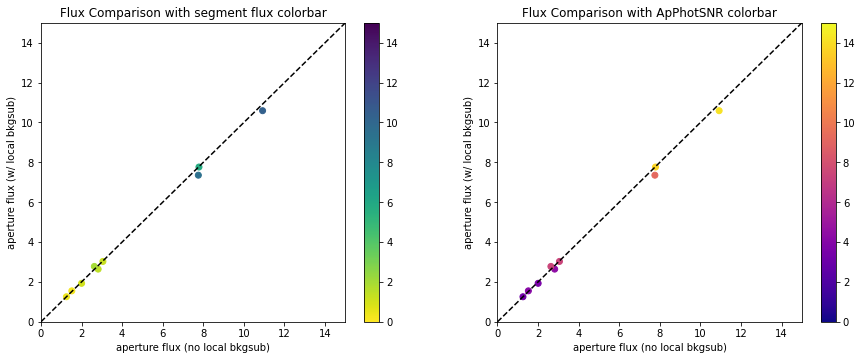

In [151]:
#a few diagnostic plots to examine background contributions to aperture flux
fig, (ax1,ax2) = plt.subplots(1, 2,figsize=(15,5.5))

ax1.set_title('Flux Comparison with segment flux colorbar')
p1=ax1.scatter(mtcut['aperture_sum_6as'],mtcut['aper_sum_bkgsub_6as'],c=mtcut['segment_flux'], cmap='viridis_r',vmin=0,vmax=15)
fig.colorbar(p1, ax=ax1)
ax1.plot([0,30],[0,30],'k--')
ax1.set_xlabel('aperture flux (no local bkgsub)')
ax1.set_ylabel('aperture flux (w/ local bkgsub)')
ax1.set_xlim(0,15)
ax1.set_ylim(0,15)

ax2.set_title('Flux Comparison with ApPhotSNR colorbar')
p2=ax2.scatter(mtcut['aperture_sum_6as'],mtcut['aper_sum_bkgsub_6as'],c=mtcut['aper_snr_6as'], cmap='plasma',vmin=0,vmax=15)
fig.colorbar(p2, ax=ax2)
ax2.plot([0,30],[0,30],'k--')
ax2.set_xlabel('aperture flux (no local bkgsub)')
ax2.set_ylabel('aperture flux (w/ local bkgsub)')
ax2.set_xlim(0,15)
ax2.set_ylim(0,15)


plt.show()

In [152]:
#write out the resulting table to file
ascii.write(mtcut, field+'_25um_cat_qcuts.dat', overwrite=True)